<a href="https://colab.research.google.com/github/JohnTaco93/Foxconn-industrial-AI-Data-Challenge/blob/master/Copy_of_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import seaborn as sns
import lightgbm as lgb
import datetime
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
import math

# Ploting styles
# styles: 'fivethirtyeight', 'classic', 'ggplot', 'seaborn-notebook'
# styles: 'seaborn-poster', 'bmh', 'grayscale', 'seaborn-whitegrid'
matplotlib.style.use('ggplot')
%matplotlib inline
pd.set_option('display.max_columns', None)
#print(plt.style.available)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
path_data = "/content/gdrive/My Drive/Foxconn2020-tool-wear/Data-Original/"

In [4]:
data01_plc = pd.read_csv(path_data+'/01-Training Data/01/PLC/plc.csv')

In [5]:
data01_plc['time']=pd.to_datetime(data01_plc.time, format = '%H:%M:%S:%f')
data01_plc.head()

,time,spindle_load,x,y,z,csv_no
0,1900-01-01 11:28:07.127,0.0824,-20.9572,-17.6915,-89.6468,1
1,1900-01-01 11:28:07.137,0.0824,-20.9572,-17.6915,-89.6468,1
2,1900-01-01 11:28:07.147,0.0824,-20.9572,-17.6915,-89.6468,1
3,1900-01-01 11:28:07.157,0.0824,-20.9572,-17.6915,-89.6468,1
4,1900-01-01 11:28:07.167,0.0824,-20.9572,-17.6915,-89.6468,1


In [6]:
data01_plc.describe()

,spindle_load,x,y,z,csv_no
count,110027.000000,110027.000000,110027.000000,110027.000000,110027.000000
mean,14.317802,-624.955347,113.454481,-436.728390,24.527625
std,5.446694,241.283467,152.304189,72.033976,13.818963
min,0.000000,-936.456200,-201.126400,-494.520000,1.000000
25%,11.499374,-801.309200,-7.970500,-474.520000,13.000000
50%,14.471877,-689.149900,106.375400,-444.520000,25.000000
75%,17.719047,-558.219300,247.263200,-427.120000,36.000000
max,37.998596,-1.108800,376.040700,0.000000,48.000000


In [7]:
data01_plc['last_time']=data01_plc['time'].max()
data01_plc['rul']=data01_plc['last_time']-data01_plc['time']
data01_plc['rul']=data01_plc['rul']/np.timedelta64(1, 'm')
data01_plc.drop(['time','last_time'],axis=1,inplace=True)

In [8]:
data01_plc.head()

,spindle_load,x,y,z,csv_no,rul
0,0.0824,-20.9572,-17.6915,-89.6468,1,300.881100
1,0.0824,-20.9572,-17.6915,-89.6468,1,300.880933
2,0.0824,-20.9572,-17.6915,-89.6468,1,300.880767
3,0.0824,-20.9572,-17.6915,-89.6468,1,300.880600
4,0.0824,-20.9572,-17.6915,-89.6468,1,300.880433


In [9]:
#creating features
data01_plc['xyz']=np.sqrt(data01_plc['x']**2+data01_plc['y']**2+data01_plc['z']**2)
data01_plc['load_pos']=data01_plc['spindle_load']*data01_plc['xyz']

In [10]:
#adding vibration dataset


In [11]:
agg_vibration=pd.read_csv('/content/gdrive/My Drive/Foxconn2020-tool-wear/Notebooks/John/new_agg_vibration.csv')
agg_vibration.head()

,csv_no,vibration_1_mean,vibration_1_std,vibration_1_max,vibration_2_mean,vibration_2_std,vibration_2_max,vibration_3_mean,vibration_3_std,vibration_3_max,current_mean,current_std,current_max,vibration_1_rms,vibration_2_rms,vibration_3_rms,vibration_1_kurt,vibration_2_kurt,vibration_3_kurt,vibration_1_cest_fct,vibration_2_cest_fct,vibration_3_cest_fct
0,1,0.032055,1.257466,10.526876,-0.013657,1.023135,9.440342,-0.008531,1.807261,29.979248,-11.138611,33.050992,68.091055,1.257874,1.023226,1.807281,2.660817,3.224526,19.469639,8.368782,9.226058,16.588040
1,2,0.033860,1.815351,13.055378,-0.009200,1.575724,12.979081,0.012159,2.029509,28.497853,-0.319054,36.355980,59.412173,1.815666,1.575751,2.029545,1.305299,2.013373,0.776188,7.190407,8.236760,14.041500
2,3,0.030849,1.904693,15.540936,-0.012517,1.649458,15.523182,0.013061,1.992761,15.933651,-0.330611,35.652936,58.783423,1.904942,1.649505,1.992803,1.631363,2.612785,0.783387,8.158221,9.410812,7.995598
3,4,0.029016,1.872942,15.947795,-0.013855,1.653137,14.723691,-0.229712,3.973331,29.999038,-0.322389,35.504967,58.372149,1.873166,1.653195,3.979965,1.587242,2.599197,20.588895,8.513819,8.906205,7.537514
4,5,0.030490,1.928085,14.677810,-0.012181,1.715352,16.262056,-0.346211,5.426306,29.999771,-0.316911,35.359442,58.205663,1.928326,1.715395,5.437338,1.686320,2.740558,11.223650,7.611686,9.480066,5.517364


In [12]:
#merging data

In [13]:
data01_plc_vibra=pd.merge(data01_plc,agg_vibration,how='left',on='csv_no')

In [14]:
data01_plc_vibra.head()

,spindle_load,x,y,z,csv_no,rul,xyz,load_pos,vibration_1_mean,vibration_1_std,vibration_1_max,vibration_2_mean,vibration_2_std,vibration_2_max,vibration_3_mean,vibration_3_std,vibration_3_max,current_mean,current_std,current_max,vibration_1_rms,vibration_2_rms,vibration_3_rms,vibration_1_kurt,vibration_2_kurt,vibration_3_kurt,vibration_1_cest_fct,vibration_2_cest_fct,vibration_3_cest_fct
0,0.0824,-20.9572,-17.6915,-89.6468,1,300.881100,93.748291,7.724859,0.032055,1.257466,10.526876,-0.013657,1.023135,9.440342,-0.008531,1.807261,29.979248,-11.138611,33.050992,68.091055,1.257874,1.023226,1.807281,2.660817,3.224526,19.469639,8.368782,9.226058,16.58804
1,0.0824,-20.9572,-17.6915,-89.6468,1,300.880933,93.748291,7.724859,0.032055,1.257466,10.526876,-0.013657,1.023135,9.440342,-0.008531,1.807261,29.979248,-11.138611,33.050992,68.091055,1.257874,1.023226,1.807281,2.660817,3.224526,19.469639,8.368782,9.226058,16.58804
2,0.0824,-20.9572,-17.6915,-89.6468,1,300.880767,93.748291,7.724859,0.032055,1.257466,10.526876,-0.013657,1.023135,9.440342,-0.008531,1.807261,29.979248,-11.138611,33.050992,68.091055,1.257874,1.023226,1.807281,2.660817,3.224526,19.469639,8.368782,9.226058,16.58804
3,0.0824,-20.9572,-17.6915,-89.6468,1,300.880600,93.748291,7.724859,0.032055,1.257466,10.526876,-0.013657,1.023135,9.440342,-0.008531,1.807261,29.979248,-11.138611,33.050992,68.091055,1.257874,1.023226,1.807281,2.660817,3.224526,19.469639,8.368782,9.226058,16.58804
4,0.0824,-20.9572,-17.6915,-89.6468,1,300.880433,93.748291,7.724859,0.032055,1.257466,10.526876,-0.013657,1.023135,9.440342,-0.008531,1.807261,29.979248,-11.138611,33.050992,68.091055,1.257874,1.023226,1.807281,2.660817,3.224526,19.469639,8.368782,9.226058,16.58804


In [15]:
data01_plc_vibra.tail()

,spindle_load,x,y,z,csv_no,rul,xyz,load_pos,vibration_1_mean,vibration_1_std,vibration_1_max,vibration_2_mean,vibration_2_std,vibration_2_max,vibration_3_mean,vibration_3_std,vibration_3_max,current_mean,current_std,current_max,vibration_1_rms,vibration_2_rms,vibration_3_rms,vibration_1_kurt,vibration_2_kurt,vibration_3_kurt,vibration_1_cest_fct,vibration_2_cest_fct,vibration_3_cest_fct
110022,0.006104,-1.1088,-201.1264,-86.207,48,0.003167,218.825741,1.335712,0.041799,0.022109,0.165339,0.003637,0.016938,0.082333,0.021226,0.02818,0.15816,-0.356437,0.07288,-0.014952,0.047285,0.017325,0.035279,0.379656,0.784662,0.264179,3.49661,4.752351,4.483106
110023,0.006104,-1.1088,-201.1264,-86.207,48,0.003000,218.825741,1.335712,0.041799,0.022109,0.165339,0.003637,0.016938,0.082333,0.021226,0.02818,0.15816,-0.356437,0.07288,-0.014952,0.047285,0.017325,0.035279,0.379656,0.784662,0.264179,3.49661,4.752351,4.483106
110024,0.006104,-1.1088,-201.1264,-86.207,48,0.000333,218.825741,1.335712,0.041799,0.022109,0.165339,0.003637,0.016938,0.082333,0.021226,0.02818,0.15816,-0.356437,0.07288,-0.014952,0.047285,0.017325,0.035279,0.379656,0.784662,0.264179,3.49661,4.752351,4.483106
110025,0.006104,-1.1088,-201.1264,-86.207,48,0.000167,218.825741,1.335712,0.041799,0.022109,0.165339,0.003637,0.016938,0.082333,0.021226,0.02818,0.15816,-0.356437,0.07288,-0.014952,0.047285,0.017325,0.035279,0.379656,0.784662,0.264179,3.49661,4.752351,4.483106
110026,0.006104,-1.1088,-201.1264,-86.207,48,0.000000,218.825741,1.335712,0.041799,0.022109,0.165339,0.003637,0.016938,0.082333,0.021226,0.02818,0.15816,-0.356437,0.07288,-0.014952,0.047285,0.017325,0.035279,0.379656,0.784662,0.264179,3.49661,4.752351,4.483106


In [16]:
#defining dependent variables and independet variable
X=data01_plc_vibra.drop(['rul'],axis=1)
y=data01_plc_vibra.rul.copy() #target

In [17]:
X.drop('csv_no',axis=1,inplace=True)

In [18]:
#spliting the data in train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [19]:
#creating the data for  Light Gradient Boosted Machine algorithm
train_data=lgb.Dataset(X_train, y_train)
test_data=lgb.Dataset(X_test, y_test, reference=train_data)

In [20]:
#training the algorithm
params = {'num_leaves': 7,
         'min_data_in_leaf': 250,
         'objective': 'regression',
         'max_depth': 8,
         #'colsample_bytree':0.2,
         'learning_rate': 0.2,
         'boosting': 'gbdt',
         'bagging_freq': 5,
         'bagging_fraction': 1,
         'feature_fraction': 1,
         'bagging_seed': 11,
         'random_state': 42,
         'metric': 'mae',
         'verbosity': -1,}
    
model = lgb.train(params,train_data,num_boost_round=10000,valid_sets = [train_data,test_data],verbose_eval=1000,early_stopping_rounds = 300)

Training until validation scores don't improve for 300 rounds.
[1000]	training's l1: 0.0777288	valid_1's l1: 0.080243
[2000]	training's l1: 0.0531579	valid_1's l1: 0.056018
[3000]	training's l1: 0.0422589	valid_1's l1: 0.0451906
[4000]	training's l1: 0.0353919	valid_1's l1: 0.0383664
[5000]	training's l1: 0.0305837	valid_1's l1: 0.0335563
[6000]	training's l1: 0.026947	valid_1's l1: 0.0298449
[7000]	training's l1: 0.0241994	valid_1's l1: 0.0269969
[8000]	training's l1: 0.0219179	valid_1's l1: 0.0245986
[9000]	training's l1: 0.0200156	valid_1's l1: 0.0226241
[10000]	training's l1: 0.0185171	valid_1's l1: 0.0210363
Did not meet early stopping. Best iteration is:
[10000]	training's l1: 0.0185171	valid_1's l1: 0.0210363


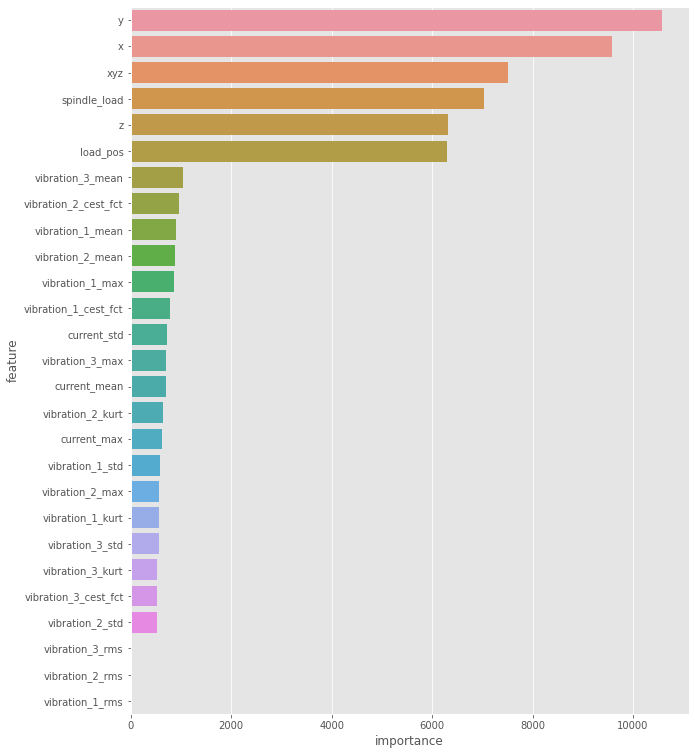

In [21]:
#feature importance
importance=pd.DataFrame()
importance['feature']=X_train.columns
importance['importance']=model.feature_importance()
f, ax = plt.subplots(figsize=(10, 13))
ax = sns.barplot(x='importance', y='feature', data=importance.sort_values(by='importance',ascending=False))

In [22]:
#OLS regression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [23]:
ols_model = sm.OLS(y, X)
ols_results = ols_model.fit()
print(ols_results.summary())

                                 OLS Regression Results                                
Dep. Variable:                    rul   R-squared (uncentered):                   0.988
Model:                            OLS   Adj. R-squared (uncentered):              0.988
Method:                 Least Squares   F-statistic:                          3.222e+05
Date:                Mon, 17 Aug 2020   Prob (F-statistic):                        0.00
Time:                        01:07:03   Log-Likelihood:                     -4.8054e+05
No. Observations:              110027   AIC:                                  9.611e+05
Df Residuals:                  110000   BIC:                                  9.614e+05
Df Model:                          27                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------